**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 02. LangGraph 기초 다지기

    - **📒[실습]** Clip 03. LangGraph 기본 사용법 - 그래프의 상태 업데이트

## 대화메시지 상태 업데이트하기

- `HumanMessage` : 사용자(사람)의 메시지

- `AIMessage` : AI(LLM)의 메시지

- `AnyMessage` : HumanMessage, AIMessage를 포함하는 메시지

In [1]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict


class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

In [2]:
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("안녕하세요! 무엇을 도와드릴까요?")

    # 노드 실행 시 state 업데이트 = 노드의 return 
    # return {"messages": new_message, "extra_field": 10} 
    return {"messages": messages + [new_message], "extra_field": 10}

`set_entry_point` : 그래프의 시작 노드를 지정하는 엣지 (START -> "node")

In [3]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node("node", node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

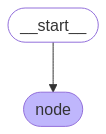

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("안녕")]})
result

{'messages': [HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

In [6]:
result["messages"]

[HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}),
 AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={})]

## 대화메시지 상태 누적 업데이트하기

`from langgraph.graph.message import add_messages` 

[add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) 는 기존 메시지에서 추가 메시지를 병합하는 데 사용하는 함수로, 새로 들어온 메시지를 추가할 때 사용할 수 있는 리듀서 역할

- 사용 예시

    ```python
    msgs1 = [HumanMessage(content="Hello", id="1")]
    msgs2 = [AIMessage(content="Hi there!", id="2")]
    add_messages(msgs1, msgs2)
    ```

In [7]:
from typing_extensions import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int

In [8]:
def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("안녕하세요! 무엇을 도와드릴까요?")

    return {"messages": new_message, "extra_field": 10}

In [9]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node("node", node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

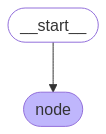

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
input_message = {"role": "user", "content": "안녕하세요."}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

안녕하세요.
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


In [12]:
result["messages"]

[HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='f2c0ac05-3ce6-4b2d-be2f-ebff4c5713d6'),
 AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='9e8b4beb-4f58-456d-9eba-2f54d9de8bce')]

## 부록) Graph 결과 호출 방식 정리하기

`invoke` : 하나의 요청에 대한 결과를 받을 때 까지 코드 실행 멈춤. 한번에 하나의 요청을 처리함

In [13]:
graph.invoke({"messages": [input_message]})

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='55b91018-1766-41fc-a3e7-1e3a262188f1'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='38609c63-22a6-4645-932c-bba9e4ab5f2f')],
 'extra_field': 10}

`ainvoke` : 비동기 처리로 여러 요청을 동시에 보낼 수 있음

In [14]:
await graph.ainvoke({"messages": [input_message]})

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='6940dfef-de1f-4ced-91f1-f4f91654a6de'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='089fee1d-ea16-432b-827c-ce2a0a4c1879')],
 'extra_field': 10}

`stream` : 중간 결과를 실시간으로 반환함

- `stream_mode="values"` 각 단계의 현재 상태 값 출력

In [15]:
for chunk in graph.stream({"messages": [input_message]}, stream_mode="values"):
    print(chunk)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='0c09dd34-e262-4c59-8253-1c68da8bd1c8')]}
================================ Human Message =================================

안녕하세요.
{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='0c09dd34-e262-4c59-8253-1c68da8bd1c8'), AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='0e40e8ab-2dcc-4619-9c31-4744a17f5b8a')], 'extra_field': 10}
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


- (Default) `stream_mode="updates"` 각 단계의 상태 업데이트만 출력

In [16]:
for chunk in graph.stream({"messages": [input_message]}, stream_mode="updates"):
    print(chunk)
    for node, value in chunk.items():
        if node:
            print(node)
        if "messages" in value:
            print(value['messages'].content)

{'node': {'messages': AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='3a20857e-6a37-4dd8-b514-eb33b780ae7a'), 'extra_field': 10}}
node
안녕하세요! 무엇을 도와드릴까요?


- `stream_mode="messages"` 각 단계의 메시지 출력 

    - 메시지
    - 메타데이터

In [17]:
for chunk_msg, metadata in graph.stream({"messages": [input_message]}, stream_mode="messages"):
    print(chunk_msg)
    print(chunk_msg.content)
    print(metadata)
    print(metadata["langgraph_node"])

content='안녕하세요! 무엇을 도와드릴까요?' additional_kwargs={} response_metadata={} id='d39ccc72-c9bb-4e73-948e-c0ad25039854'
안녕하세요! 무엇을 도와드릴까요?
{'langgraph_step': 1, 'langgraph_node': 'node', 'langgraph_triggers': ('branch:to:node', 'start:node'), 'langgraph_path': ('__pregel_pull', 'node'), 'langgraph_checkpoint_ns': 'node:7bf5dbc5-bb4e-e12d-84d8-feb9e26b5993'}
node


`astream` : 비동기 방식으로 스트리밍 처리

In [18]:
async for chunk_msg, metadata in graph.astream({"messages": [input_message]}, stream_mode="messages"):
    print(chunk_msg)
    print(chunk_msg.content)
    print(metadata)
    print(metadata["langgraph_node"])

content='안녕하세요! 무엇을 도와드릴까요?' additional_kwargs={} response_metadata={} id='ff77916a-a34d-4ea3-9eeb-225ed3b70984'
안녕하세요! 무엇을 도와드릴까요?
{'langgraph_step': 1, 'langgraph_node': 'node', 'langgraph_triggers': ('branch:to:node', 'start:node'), 'langgraph_path': ('__pregel_pull', 'node'), 'langgraph_checkpoint_ns': 'node:ae21d541-c5c9-ebf2-8ad6-bf791412153c'}
node
